# Two dimensional FDTD code for plasmonics

In [119]:
"""2D FDTD with YEE-Algorithmus: leapfrog and staggered grid according to 
    Taflove's book
    - in vacuum with Debye material
    - BC: PEC and PML
    - TE-mode

Richard Ciesielski
"""
%load_ext autoreload
%autoreload 2

import numpy
from numpy import pi
import pylab
%matplotlib inline

# Simulation libraries:
import fdtd_core as core
import fdtd_excitations as exc
import fdtd_objects as obj
import fdtd_visualization as vis


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting up the simulation

In [120]:
# create a mesh:
lengthx = 25.
lengthy = 20.
Nx = 301                            # number of nodes for the E-field
dx = lengthx / (Nx - 1)
Ny =  int(lengthy / dx + 1)
lengthy = (Ny - 1) * dx             # adjust the length

# produce a staggered grid with NxN nodes:
grid = core.staggered_grid_2D(lengthx, lengthy, Nx, Ny)

# add PMLs:
grid.addPML(1.5, "right", 11., "full")
grid.addPML(1.5, "left", 11., "full")
grid.addPML(1.5, "up", 11.)
grid.addPML(1.5, "down", 11.)

# add scatterer:
wp = 4
wj = 1
gamma = 1
obj.addDielectricCircle(grid, 
    x=10, y=lengthy / 2., R=3., n = 1.5)


print "Plasma frequency: ", wp

# for later calculations:
dummy_grid = core.staggered_grid_2D(lengthx, lengthy, Nx, Ny)

# add excitation:
excitations = []
excitations.append(exc.testpulse_x_Exc(x=4, H=1, sigma=1, rc=2))

dt = grid.dt / 2.

grid.dt = dt
dummy_grid.dt = dt

w_probe = 3

Plasma frequency:  4


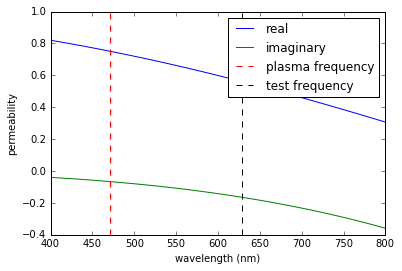

In [107]:
# now calculate and plot the theoretical frequency response
wl = numpy.linspace(400,800,101)
w = 2 * pi * 3e2 / wl
eps = 1 + wp  / (wj**2 + 1j * w * gamma - w**2)

pylab.figure()
pylab.plot(wl, eps.real, label="real")
pylab.plot(wl, eps.imag, c='g', label="imaginary")
pylab.axvline(2*pi*3e2 / wp, ls='--', c='r', label="plasma frequency")
pylab.axvline(2*pi*3e2 / w_probe, ls='--', c='k', label="test frequency")
pylab.xlabel('wavelength (nm)')
pylab.ylabel('permeability')
pylab.legend()


## Executing the simulation

In [121]:
grid.updateConstants()              # absolutely necessary
t, t_end = 0, 120.                   # duration of the simulation
cycles = int((t_end - t) / dt)      # total number of cycles
time = numpy.linspace(t, t_end, cycles)

print "number of nodes :",Nx, "x", Ny,"=", Nx*Ny, \
        "\t time step :",dt,  "\t cycles :", cycles

# observation of numerical divergences in Ex,Ey,Hz:
bookkeeping = numpy.zeros(cycles)
Ex_w = numpy.zeros(grid.Ex.shape, dtype=complex)
Ey_w = numpy.zeros(grid.Ey.shape, dtype=complex)
Hz_w = numpy.zeros(grid.Hz.shape, dtype=complex)

for i in range(cycles):             # main loop
    grid.oEx, grid.oEy, grid.oJx, grid.oJy, \
        grid.Ex, grid.Ey, grid.Jx, grid.Jy, grid.Hz = \
            core.CalculationStep(grid, dummy_grid, t, excitations)
    
    
    # calculate the actual absolute value of the Poynting vector:
    S = numpy.sqrt((grid.Ey* grid.Hz[:, :-1])**2 + 
                                 (grid.Ex[:-1, :-1]  * grid.Hz[:, :-1])**2)
    
    # keep track of the convergence
    bookkeeping[i] = numpy.sum(S)
    
    # calculate the Fourier transform at the frequency w_probe
    Ex_w+= numpy.exp(1j * t * w_probe) * grid.Ex
    Ey_w+= numpy.exp(1j * t * w_probe) * grid.Ey
    Hz_w+= numpy.exp(1j * t * w_probe) * grid.Hz
    
    # print progress:
    if cycles > 20:
        if i % int(cycles / 20) == 0: print "simulation time left: ", t_end - t, " energy: ", bookkeeping[i]
            
    t = t + dt

print "done"

number of nodes : 301 x 241 = 72541 	 time step : 0.0972212312311 	 cycles : 1234
simulation time left:  120.0  energy:  86.7992613868
simulation time left:  114.069504895  energy:  15983.5378406
simulation time left:  108.13900979  energy:  9142.7825606
simulation time left:  102.208514685  energy:  7929.06976212
simulation time left:  96.2780195796  energy:  7921.73667643
simulation time left:  90.3475244745  energy:  8013.10507684
simulation time left:  84.4170293694  energy:  8141.38053927
simulation time left:  78.4865342643  energy:  8143.16188906
simulation time left:  72.5560391592  energy:  8145.94747195
simulation time left:  66.6255440541  energy:  8146.30538147
simulation time left:  60.6950489491  energy:  8144.58701438
simulation time left:  54.764553844  energy:  6312.29102219
simulation time left:  48.8340587389  energy:  280.572691693
simulation time left:  42.9035636338  energy:  63.2258226693
simulation time left:  36.9730685287  energy:  70.8145391966
simulation tim

## Postprocessing and Plotting

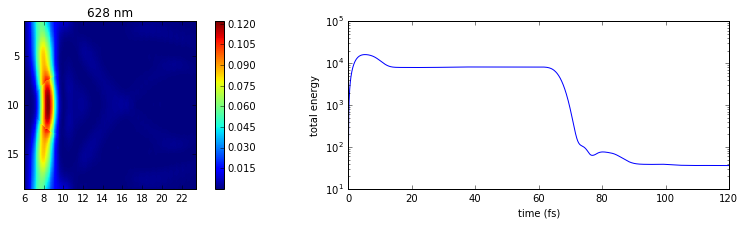

In [123]:
S_w = numpy.sqrt((Ey_w * Hz_w[:, :-1])**2 + 
                                 (Ex_w[:-1, :-1]  * Hz_w[:, :-1])**2)
pylab.figure(figsize=(15,3))
pylab.subplot(121)
#pylab.imshow(abs(S_w))
vis.plot_matrix(abs(S_w), grid, 0, xlim=(6,50))
pylab.colorbar()
pylab.title('%d nm' % (2*pi*3e2 / w_probe))

pylab.subplot(122)
pylab.semilogy(time, bookkeeping)
pylab.xlabel('time (fs)')
pylab.ylabel('total energy')

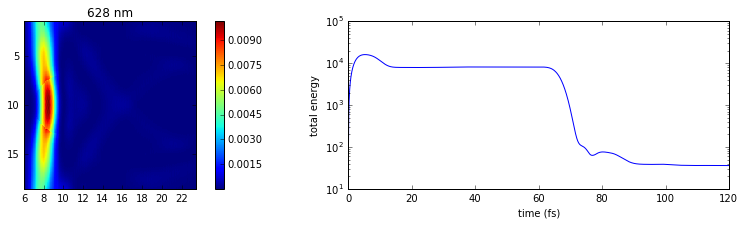

In [118]:
S_w = numpy.sqrt((Ey_w * Hz_w[:, :-1])**2 + 
                                 (Ex_w[:-1, :-1]  * Hz_w[:, :-1])**2)
pylab.figure(figsize=(15,3))
pylab.subplot(121)
#pylab.imshow(abs(S_w))
vis.plot_matrix(abs(S), grid, 0, xlim=(6,50))
pylab.colorbar()
pylab.title('%d nm' % (2*pi*3e2 / w_probe))
pylab.subplot(122)
pylab.semilogy(time, bookkeeping)
pylab.xlabel('time (fs)')
pylab.ylabel('total energy')



In [63]:
grid.dt

0.19444246246212099